In [7]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import cv2
import tqdm
from sklearn.model_selection import StratifiedKFold

In [8]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


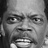

In [9]:
# loading a sample image
sample_image = Image.open("/content/gdrive/My Drive/Train_Relabeled_Cleaned/angry/10.jpg")
sample_image

In [ ]:
np.array(sample_image).shape

(48, 48)

In [10]:
# normalize all the images from the dataset
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([200,200])
    # if len(np.array(image).shape) == 3:
    #     image = image.sum(axis=2)
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)


In [11]:
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Train_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

(22036, 200, 200, 1) (22036, 7)
(5510, 200, 200, 1) (5510, 7)


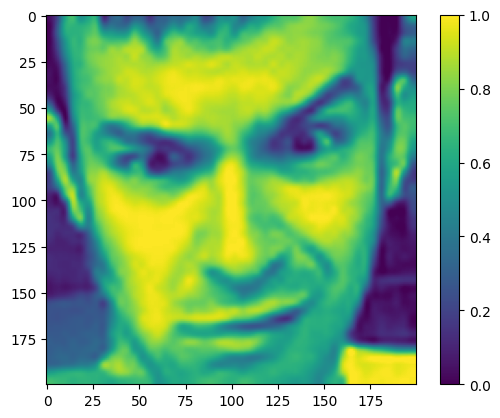

In [12]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 200, 200, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

# Obstruct the Top 1/4 of the Facial Images

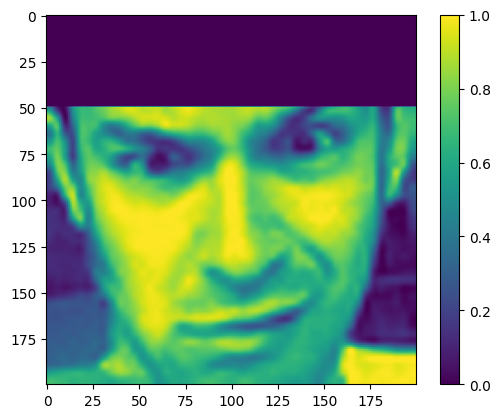

In [13]:
# obstruct the top 1/3 of the image
x_train_obstructed_up = x_train.copy()
x_train_obstructed_up[:,:50,:,:] = 0
x_val_obstructed_up = x_val.copy()
x_val_obstructed_up[:,:50,:,:] = 0

plt.imshow(x_train_obstructed_up[0,:,:,0])
plt.colorbar()

In [14]:
# train and fit a resnet50 model
resnet50_model_top = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_obstructed_up[0].shape, pooling=None, classes=7)

# model summary
resnet50_model_top.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [15]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_top.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [16]:
n_epoch = 30
# train the model
resnet50_model_top.fit(x_train_obstructed_up, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val_obstructed_up, y_val),
                callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 90s 62ms/step - loss: 1.8122 - categorical_accuracy: 0.2748 - val_loss: 2.0777 - val_categorical_accuracy: 0.2677
Epoch 2/30
689/689 [==============================] - 39s 57ms/step - loss: 1.6084 - categorical_accuracy: 0.3777 - val_loss: 2.3167 - val_categorical_accuracy: 0.2361
Epoch 3/30
689/689 [==============================] - 39s 57ms/step - loss: 1.4446 - categorical_accuracy: 0.4451 - val_loss: 1.5833 - val_categorical_accuracy: 0.4194
Epoch 4/30
689/689 [==============================] - 39s 57ms/step - loss: 1.3080 - categorical_accuracy: 0.4989 - val_loss: 1.9144 - val_categorical_accuracy: 0.3541
Epoch 5/30
689/689 [==============================] - 39s 57ms/step - loss: 1.1852 - categorical_accuracy: 0.5504 - val_loss: 1.5235 - val_categorical_accuracy: 0.4267
Epoch 6/30
689/689 [==============================] - 39s 57ms/step - loss: 1.0743 - categorical_accuracy: 0.5938 - val_loss: 1.3881 - val_categorical_accuracy:

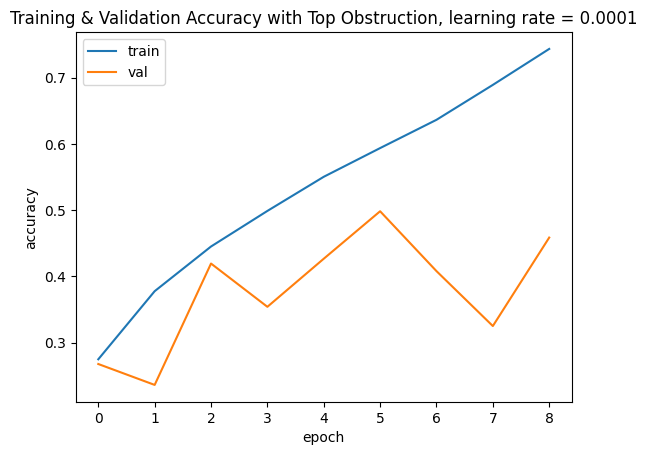

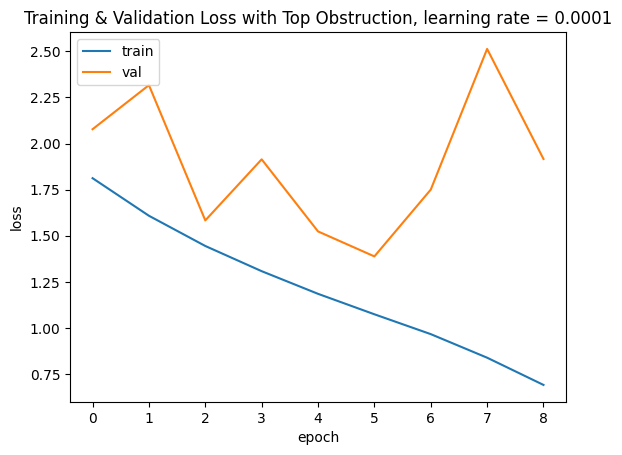

In [17]:
# plot the accuracy and loss
plt.plot(resnet50_model_top.history.history['categorical_accuracy'])
plt.plot(resnet50_model_top.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy with Top Obstruction, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_top.history.history['loss'])
plt.plot(resnet50_model_top.history.history['val_loss'])
plt.title('Training & Validation Loss with Top Obstruction, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [18]:
# save the model
resnet50_model_top.save_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_upper_face')

In [19]:
resnet50_model_top.load_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_upper_face')

# Test For the Top 1/4 of the Facial Images

In [21]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

In [20]:
x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 200, 200, 1)
y_test = np.array(y_test)

y_test = np.eye(len(emo_types))[y_test]
print(x_test.shape, y_test.shape)

(6488, 200, 200, 1) (6488, 7)


In [22]:
# Evaluate the model
loss, acc = resnet50_model_top.evaluate(x_test, y_test, verbose=2)
print("The accuracy of the Resnet50 model with obstruction on the top 1/4 is: {:5.2f}%".format(100 * acc))
y_pred = resnet50_model_top.predict(x_test, verbose=2)

203/203 - 3s - loss: 2.8867 - categorical_accuracy: 0.3340 - 3s/epoch - 14ms/step
The accuracy of the Resnet50 model with obstruction on the top 1/4 is: 33.40%
203/203 - 3s - 3s/epoch - 16ms/step


In [23]:
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.34      0.12      0.17       888
           1       0.03      0.71      0.05        83
           2       0.29      0.18      0.22       916
           3       0.57      0.83      0.68      1752
           4       0.78      0.02      0.03      1181
           5       0.39      0.10      0.16      1088
           6       0.54      0.44      0.49       580

    accuracy                           0.33      6488
   macro avg       0.42      0.34      0.26      6488
weighted avg       0.50      0.33      0.32      6488



In [24]:
# the f1 socre of the weighted average
f1_score(y_test, y_pred, average='weighted')

0.3151799325287889

In [36]:
f1_score(y_test, y_pred, average=None)[6]

0.48725212464589235

In [34]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.11711712, 0.71084337, 0.18122271, 0.82762557, 0.01524132,
       0.10294118, 0.44482759])

# Obstruct the Middle 1/4 of the Facial Images

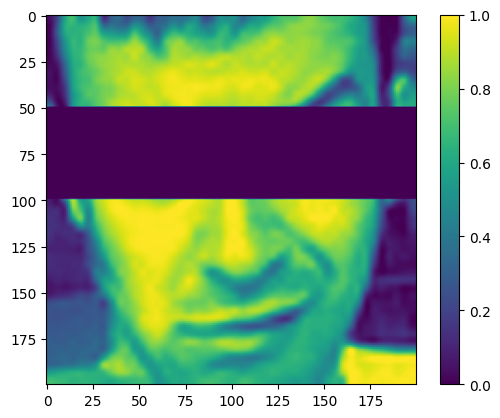

In [37]:
# obstruct the middle 1/4 of the images
x_train_obstructed_middle = x_train.copy()
x_train_obstructed_middle[:, 50:100, :, :] = 0
x_val_obstructed_middle = x_val.copy()
x_val_obstructed_middle[:, 50:100, :, :] = 0

plt.imshow(x_train_obstructed_middle[0,:,:,0])
plt.colorbar()

In [38]:
# train a resnet50 model
resnet50_model_middle = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_obstructed_middle[0].shape, pooling=None, classes=7)

# model summary
resnet50_model_middle.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [39]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_middle.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [40]:
n_epoch = 30
# train the model
resnet50_model_middle.fit(x_train_obstructed_middle, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val_obstructed_middle, y_val),
                callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 76s 59ms/step - loss: 1.8115 - categorical_accuracy: 0.2772 - val_loss: 2.1730 - val_categorical_accuracy: 0.2760
Epoch 2/30
689/689 [==============================] - 40s 58ms/step - loss: 1.6645 - categorical_accuracy: 0.3502 - val_loss: 1.8595 - val_categorical_accuracy: 0.3071
Epoch 3/30
689/689 [==============================] - 39s 57ms/step - loss: 1.5434 - categorical_accuracy: 0.4072 - val_loss: 1.8450 - val_categorical_accuracy: 0.3074
Epoch 4/30
689/689 [==============================] - 39s 57ms/step - loss: 1.4300 - categorical_accuracy: 0.4517 - val_loss: 1.9642 - val_categorical_accuracy: 0.2701
Epoch 5/30
689/689 [==============================] - 39s 57ms/step - loss: 1.3337 - categorical_accuracy: 0.4910 - val_loss: 1.7249 - val_categorical_accuracy: 0.4015
Epoch 6/30
689/689 [==============================] - 40s 57ms/step - loss: 1.2299 - categorical_accuracy: 0.5357 - val_loss: 1.6858 - val_categorical_accuracy:

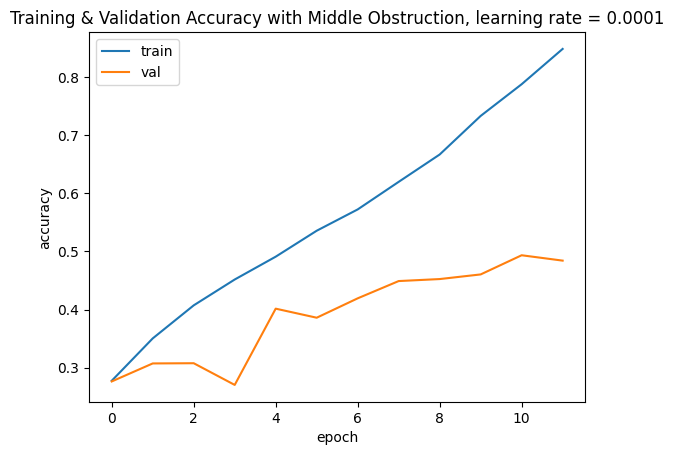

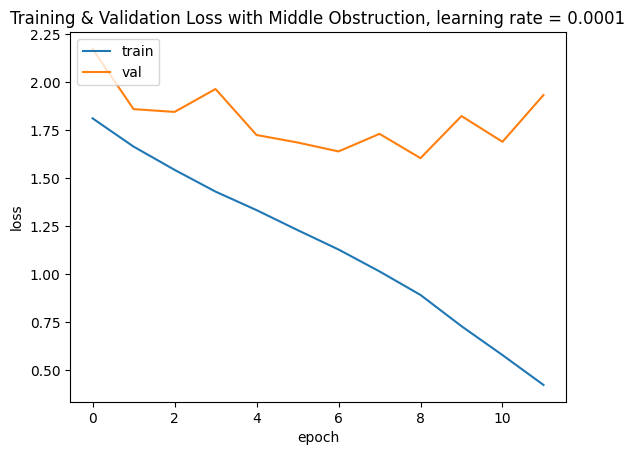

In [41]:
# plot the accuracy and loss
plt.plot(resnet50_model_middle.history.history['categorical_accuracy'])
plt.plot(resnet50_model_middle.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy with Middle Obstruction, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_middle.history.history['loss'])
plt.plot(resnet50_model_middle.history.history['val_loss'])
plt.title('Training & Validation Loss with Middle Obstruction, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [42]:
# save the model
resnet50_model_middle.save_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_middle_face')

# Test For the Middle 1/4 of the Facial Images

In [53]:
x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 200, 200, 1)
y_test = np.array(y_test)

y_test = np.eye(len(emo_types))[y_test]
print(x_test.shape, y_test.shape)

(6488, 200, 200, 1) (6488, 7)


In [54]:
# Evaluate the model
loss, acc = resnet50_model_middle.evaluate(x_test, y_test, verbose=2)
print("The accuracy of the Resnet50 model with the middle 1/4 obstruction is: {:5.2f}%".format(100 * acc))
y_pred = resnet50_model_middle.predict(x_test, verbose=2)

203/203 - 3s - loss: 2.5267 - categorical_accuracy: 0.4274 - 3s/epoch - 12ms/step
The accuracy of the Resnet50 model with the middle 1/4 obstruction is: 42.74%
203/203 - 2s - 2s/epoch - 12ms/step


In [55]:
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.05      0.08       888
           1       0.50      0.08      0.14        83
           2       0.22      0.62      0.33       916
           3       0.65      0.79      0.71      1752
           4       0.45      0.40      0.42      1181
           5       0.41      0.21      0.28      1088
           6       0.85      0.12      0.21       580

    accuracy                           0.43      6488
   macro avg       0.49      0.32      0.31      6488
weighted avg       0.49      0.43      0.40      6488



In [56]:
# the f1 socre of the weighted average
f1_score(y_test, y_pred, average='weighted')

0.3954508721301373

In [63]:
f1_score(y_test, y_pred, average=None)[6]

0.21148036253776437

In [51]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.0472973 , 0.08433735, 0.62117904, 0.78767123, 0.40135478,
       0.21231618, 0.12068966])

# Obstruct the Bottom 1/2 of the Facial Images



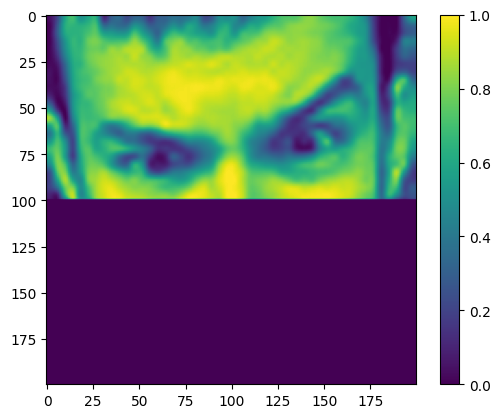

In [64]:
# obstruct the rest of the image, train and fit the resnet50 model
x_train_obstructed_bottom = x_train.copy()
x_train_obstructed_bottom[:, 100:, :, :] = 0
x_val_obstructed_bottom = x_val.copy()
x_val_obstructed_bottom[:, 100:, :, :] = 0

plt.imshow(x_train_obstructed_bottom[0,:,:,0])
plt.colorbar()

In [65]:
# train a resnet50 model
resnet50_model_bottom = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_obstructed_bottom[0].shape, pooling=None, classes=7)

# model summary
resnet50_model_bottom.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [66]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_bottom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [67]:
n_epoch = 30
# train the model
resnet50_model_bottom.fit(x_train_obstructed_bottom, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val_obstructed_bottom, y_val),
                callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 76s 59ms/step - loss: 1.8628 - categorical_accuracy: 0.2392 - val_loss: 2.1111 - val_categorical_accuracy: 0.1730
Epoch 2/30
689/689 [==============================] - 39s 57ms/step - loss: 1.8202 - categorical_accuracy: 0.2557 - val_loss: 1.8738 - val_categorical_accuracy: 0.2702
Epoch 3/30
689/689 [==============================] - 39s 57ms/step - loss: 1.7606 - categorical_accuracy: 0.2867 - val_loss: 1.8425 - val_categorical_accuracy: 0.2661
Epoch 4/30
689/689 [==============================] - 40s 58ms/step - loss: 1.6749 - categorical_accuracy: 0.3339 - val_loss: 1.7337 - val_categorical_accuracy: 0.2935
Epoch 5/30
689/689 [==============================] - 41s 59ms/step - loss: 1.5840 - categorical_accuracy: 0.3760 - val_loss: 1.8609 - val_categorical_accuracy: 0.3065
Epoch 6/30
689/689 [==============================] - 41s 59ms/step - loss: 1.4999 - categorical_accuracy: 0.4147 - val_loss: 1.6426 - val_categorical_accuracy:

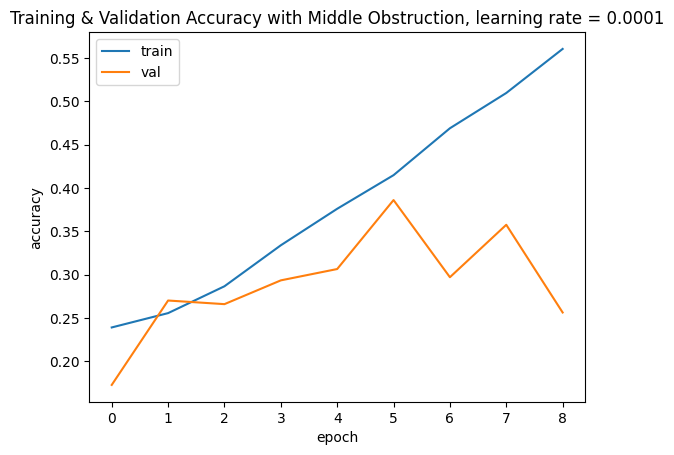

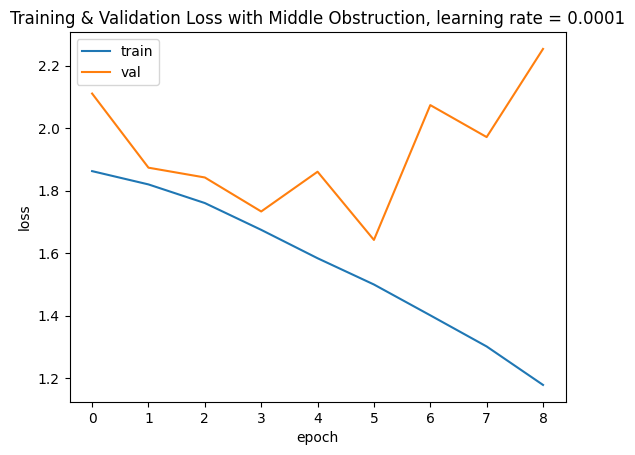

In [68]:
# plot the accuracy and loss
plt.plot(resnet50_model_bottom.history.history['categorical_accuracy'])
plt.plot(resnet50_model_bottom.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy with Middle Obstruction, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_bottom.history.history['loss'])
plt.plot(resnet50_model_bottom.history.history['val_loss'])
plt.title('Training & Validation Loss with Middle Obstruction, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [69]:
# save the model
resnet50_model_bottom.save_weights('/content/gdrive/My Drive/IDS705/resnet50_model_bn_bottom_face')

# Test For the Bottom 1/2 of the Facial Images


In [70]:
x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Validation_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 200, 200, 1)
y_test = np.array(y_test)

y_test = np.eye(len(emo_types))[y_test]
print(x_test.shape, y_test.shape)

(6488, 200, 200, 1) (6488, 7)


In [72]:
# Evaluate the model
loss, acc = resnet50_model_bottom.evaluate(x_test, y_test, verbose=2)
print("The accuracy of the Resnet50 model with the bottom 1/2 obstruction is: {:5.2f}%".format(100 * acc))
y_pred = resnet50_model_bottom.predict(x_test, verbose=2)

203/203 - 3s - loss: 2.9600 - categorical_accuracy: 0.2022 - 3s/epoch - 13ms/step
The accuracy of the Resnet50 model with the bottom 1/2 obstruction is: 20.22%
203/203 - 2s - 2s/epoch - 12ms/step


In [73]:
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.17      0.64      0.27       888
           1       0.00      0.00      0.00        83
           2       0.20      0.41      0.27       916
           3       0.37      0.01      0.03      1752
           4       0.00      0.00      0.00      1181
           5       0.25      0.23      0.24      1088
           6       0.46      0.17      0.25       580

    accuracy                           0.20      6488
   macro avg       0.21      0.21      0.15      6488
weighted avg       0.24      0.20      0.14      6488



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
# the f1 socre of the weighted average
f1_score(y_test, y_pred, average='weighted')

0.1443615251568321

In [82]:
f1_score(y_test, y_pred, average=None)[6]

0.2503128911138924

In [84]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.63513514, 0.        , 0.40829694, 0.01426941, 0.        ,
       0.22886029, 0.17241379])